## Cost Profiling openEO processes (UDP)

In this notebook we detail how one can profile the credit cost of a openEO process. Providing such information can by highly informative when sharing the process with other users, or when trying to optimize its credit usage. 

In this example we will profile the `eurac_pv_farm_detection` udp as a function of the spatial and temporal input size.

**Note** The profiled credit cost, is only applicable for the openEO job configuration  [openEO job configuration](https://documentation.dataspace.copernicus.eu/APIs/openEO/job_config.html) used.  Fine-tuning memory settings, can make algorithm run more cost efficient. Optimizing the algorithm performance is offered as a service by [APEx](https://apex.esa.int/algorithm-services)


In [22]:
import pandas as pd
import openeo

from openeo.extra.job_management import (
        CsvJobDatabase,
        ProcessBasedJobCreator,
        MultiBackendJobManager
    )


For this example we will use an existing APEx algorithm from the catalog, but it is also relatively easy to work with any other openEO process. More examples can be found in [openEO community examples](https://github.com/Open-EO/openeo-community-examples/tree/main/python/ManagingMultipleLargeScaleJobs)

In [2]:
process_graph_url = "https://raw.githubusercontent.com/ESA-APEx/apex_algorithms/refs/heads/hv_notebook_fix/algorithm_catalog/vito/eurac_pv_farm_detection/openeo_udp/eurac_pv_farm_detection.json"
process_id = "eurac_pv_farm_detection"

## Prepare jobs database

In order to profile the openEO process, we will make use of openEO's `MultiBackendJobManager`. This Job manager requires oen to set up a dataframe which contains all input parameters for the jobs we wish to run.

Hence we will create a dataframe containing all combinations of the input variables over which we want to profile the openEO process. 

**Note:** Since the used openeo process `eurac_pv_farm_detection` accepts as inpuit parameters a `bbox` and a `temporal_extent`, it is important that the collumns in the dataframe are named accordingly

In [3]:
from utils import prepare_jobs_df

BASE_SPATIAL = {"west": 664000.0, "south": 5611120.0, "crs": "EPSG:32631", "srs": "EPSG:32631"}
BASE_TEMPORAL = '2024-01-01'

spatial_extents = [10000, 20000, 40000] #km extend
temporal_extents = [3, 6, 12] #months

jobs_df = prepare_jobs_df(spatial_extents, temporal_extents, BASE_SPATIAL, BASE_TEMPORAL)
print(jobs_df)

                                                bbox           temporal_extent
0  {'west': 5.318868004541495, 'south': 50.625959...  [2024-01-01, 2024-04-01]
1  {'west': 5.318868004541495, 'south': 50.625959...  [2024-01-01, 2024-07-01]
2  {'west': 5.318868004541495, 'south': 50.625959...  [2024-01-01, 2025-01-01]
3  {'west': 5.318868004541495, 'south': 50.622890...  [2024-01-01, 2024-04-01]
4  {'west': 5.318868004541495, 'south': 50.622890...  [2024-01-01, 2024-07-01]
5  {'west': 5.318868004541495, 'south': 50.622890...  [2024-01-01, 2025-01-01]
6  {'west': 5.318868004541495, 'south': 50.616238...  [2024-01-01, 2024-04-01]
7  {'west': 5.318868004541495, 'south': 50.616238...  [2024-01-01, 2024-07-01]
8  {'west': 5.318868004541495, 'south': 50.616238...  [2024-01-01, 2025-01-01]


## Creating the Job
Once we have created our dataframe containing the input parameters, we do need to tell the job manager what to do with those parameters. Therefore, we create an openEO job. For openEO processes we can effectively use the `ProcessBasedJobCreator` to create a valid openEO job. 

In [15]:
start_job = ProcessBasedJobCreator(process_id=process_id, namespace=process_graph_url)

## Running Jobs Using MultiBackendJobManager

With our spatial extents set up, we can now run the jobs using the `MultiBackendJobManager`. This involves defining an output file where the job tracker will store the job statuses and metadata.

### Steps to Run the Jobs:

1. Define the Output File:
   The output file will store the job tracker data, including job statuses and metadata.

2. Initialize the MultiBackendJobManager:
   We create an instance of the `MultiBackendJobManager` and add a backend of our choice. This backend will be responsible for executing the jobs.

3. Run Multiple Jobs:
   Use `manager.run_jobs` to create the desired jobs and send them to the backend.
   The output file, defined in step 1, will act as a the live job tracker and contain all the information from the original jobs DataFrame, as well as updates on the actual job statuses.


In [ ]:

# Initiate MultiBackendJobManager 
job_manager = MultiBackendJobManager()  
connection = openeo.connect(url="openeo.dataspace.copernicus.eu").authenticate_oidc()
job_manager.add_backend("cdse", connection=connection, parallel_jobs=2)

job_tracker = 'jobs.csv'
job_db = CsvJobDatabase(path=job_tracker)
job_db.initialize_from_df(jobs_df)

job_manager.run_jobs(start_job=start_job, job_db=job_db)

Authenticated using refresh token.


defaultdict(int,
            {'job_db persist': 16,
             'track_statuses': 7,
             'job_db get_by_status': 1,
             'start_job call': 9,
             'job get status': 18,
             'job start': 9,
             'job launch': 9,
             'run_jobs loop': 7,
             'sleep': 7,
             'job describe': 30,
             'job finished': 9,
             'job started running': 7})

Once the jobs have finished, we reconnect to each job using the job-id and add the cost information into the dataframe. 
This step will become deprecated in the future as the job cost will be added to the job manager as a standard.

In [ ]:
from utils import update_job_costs_dataframe

df = pd.read_csv(job_tracker)
if not 'job_cost' in df:
    df = update_job_costs_dataframe(df, connection)

df

Authenticated using refresh token.


,bbox,temporal_extent,status,id,start_time,running_start_time,cpu,memory,duration,backend_name,job_cost
0,"{'west': 5.318868004541495, 'south': 50.625959...","['2024-01-01', '2024-04-01']",finished,j-2502211427304f819db0f343c822dbe2,2025-02-21T14:27:32Z,NaN,770.7401148490001 cpu-seconds,7267329.687500002 mb-seconds,200 seconds,cdse,6.0
1,"{'west': 5.318868004541495, 'south': 50.625959...","['2024-01-01', '2024-07-01']",finished,j-2502211428154f598a2fd60b00463466,2025-02-21T14:28:16Z,2025-02-21T14:32:52Z,1456.868555183 cpu-seconds,9084338.80859375 mb-seconds,260 seconds,cdse,7.0
2,"{'west': 5.318868004541495, 'south': 50.625959...","['2024-01-01', '2025-01-01']",finished,j-2502211428324cea9407ceb1dfaa1a13,2025-02-21T14:28:33Z,NaN,2591.5910848340004 cpu-seconds,13787584.648437504 mb-seconds,339 seconds,cdse,9.0
3,"{'west': 5.318868004541495, 'south': 50.622890...","['2024-01-01', '2024-04-01']",finished,j-2502211429204534ace9e924c2c44cef,2025-02-21T14:29:20Z,2025-02-21T14:32:53Z,715.331727992 cpu-seconds,5497511.210937499 mb-seconds,190 seconds,cdse,5.0
4,"{'west': 5.318868004541495, 'south': 50.622890...","['2024-01-01', '2024-07-01']",finished,j-2502211429374dd4b77c4cee08d4b95c,2025-02-21T14:29:38Z,2025-02-21T14:32:55Z,1479.0923398060002 cpu-seconds,9461219.009375 mb-seconds,259 seconds,cdse,7.0
5,"{'west': 5.318868004541495, 'south': 50.622890...","['2024-01-01', '2025-01-01']",finished,j-2502211430064a96a3bac4f5b9ff8e7a,2025-02-21T14:30:06Z,2025-02-21T14:32:56Z,2531.599976633 cpu-seconds,16368920.707087057 mb-seconds,417 seconds,cdse,10.0
6,"{'west': 5.318868004541495, 'south': 50.616238...","['2024-01-01', '2024-04-01']",finished,j-25022114302747a5a8fc39fd13403b61,2025-02-21T14:30:27Z,2025-02-21T14:33:09Z,798.0674027809999 cpu-seconds,6458700.921223959 mb-seconds,215 seconds,cdse,6.0
7,"{'west': 5.318868004541495, 'south': 50.616238...","['2024-01-01', '2024-07-01']",finished,j-2502211431054f91b6b74d04c2cd23f3,2025-02-21T14:31:05Z,2025-02-21T14:33:09Z,1386.7766356719999 cpu-seconds,9796064.688281251 mb-seconds,279 seconds,cdse,7.0
8,"{'west': 5.318868004541495, 'south': 50.616238...","['2024-01-01', '2025-01-01']",finished,j-250221143123401cb3e0308104cda500,2025-02-21T14:31:24Z,2025-02-21T14:33:09Z,2409.3242652500003 cpu-seconds,14868502.516815476 mb-seconds,388 seconds,cdse,10.0


# Metrics plots

Results are plotted to allow visual inspection.

The plot shows cost as a function of the spatial and temporal extent. 

These visualisation can help estimate the openEO cost when one wishes to run the undelrying process on a larger scale.

**Note:** The output job cost, are directly related to the used memory settings, and can always be improved. Support on optimizing openEO processes can be obtained through [APEx](https://apex.esa.int/algorithm-services)


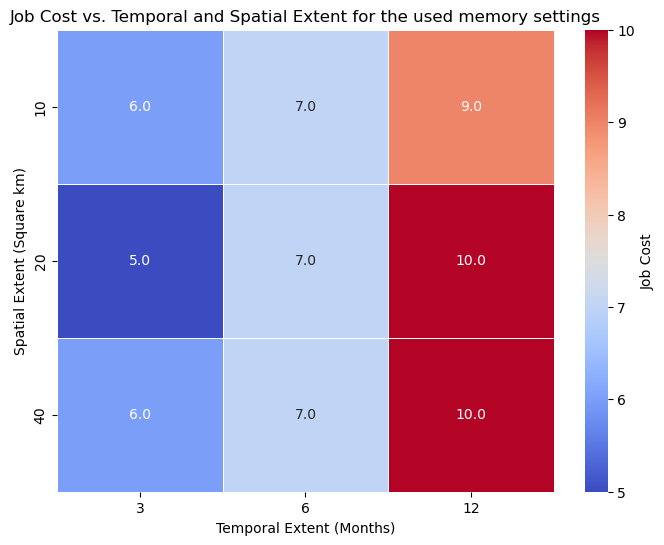

In [23]:
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import ast  # For safely converting string to dictionary

def plot_job_costs(df):
    # Ensure bbox is a dictionary
    df['bbox'] = df['bbox'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    df['temporal_extent'] = df['temporal_extent'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    # Extracting spatial and temporal extent
    df['lat_span'] = df['bbox'].apply(lambda b: round((b['north'] - b['south']) * 108))  # Convert latitude span to km
    df['temporal_months'] = df['temporal_extent'].apply(lambda t: round((pd.to_datetime(t[1]) - pd.to_datetime(t[0])).days / 30))

    # Pivot the data for heatmap plotting
    pivot_table = df.pivot_table(index='lat_span', columns='temporal_months', values='job_cost', aggfunc='mean')

    # Create the heatmap
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(pivot_table, annot=True, fmt='.1f', cmap='coolwarm', linewidths=0.5, cbar_kws={'label': 'Job Cost'})

    # Labels and title
    plt.xlabel('Temporal Extent (Months)')
    plt.ylabel('Spatial Extent (Square km)')
    plt.title('Job Cost vs. Temporal and Spatial Extent for the used memory settings')
    plt.show()

# Example usage (assuming df is your DataFrame)
plot_job_costs(df)